In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support as scores
from statistics import variance
import matplotlib.pyplot as plt

import psycopg2
import pandas.io.sql as sqlio
import psycopg2.extras


In [5]:
# Establish a connection to the PLUTO database
try:
    conn = psycopg2.connect("dbname='pluto' user='oliver' host='localhost' password='m'")
except:
    print("I am unable to connect to the database")

# Create a cursor object for executing queries
conn.autocommit = True
cur = conn.cursor()

In [6]:
    cov_forest = [
    'xcoord'
    ,'ycoord'
    ,'age'
    ,'build_alter_gap'
    ,'alterage'      
    ,'elevator'
    ,'commercial'
    ,'garage'
    ,'storage'
    ,'basement'
    ,'waterfront'
    ,'frontage'
    ,'block_assmeblage'
    ,'cooperative'
    ,'conv_loft_wh'
    ,'tenament'
    ,'garden'
    ,'semi_fireproof'
    ,'fireproof'
    ,'luxury'
    ,'artist_res'
    ,'units_per_building'
    ,'floors'
    ,'zip_avg_num_buildings'
    ,'pcvpu_l1'
    ,'pcvpu_l2'
    ,'pcvpu_l3'
    ,'avg_block_pcvpu_l1'
    ,'avg_block_pcvpu_l2'
    ,'avg_block_pcvpu_l3'
    ,'avg_neighbor1_pcvpu_l1'
    ,'avg_neighbor1_pcvpu_l2'
    ,'avg_neighbor1_pcvpu_l3'
    ,'avg_neighbor2_pcvpu_l1'
    ,'avg_neighbor2_pcvpu_l2'
    ,'avg_neighbor2_pcvpu_l3'
    ,'avg_neighbor3_pcvpu_l1'
    ,'avg_neighbor3_pcvpu_l2'
    ,'avg_neighbor3_pcvpu_l3'
    ,'avg_neighbor4_pcvpu_l1'
    ,'avg_neighbor4_pcvpu_l2'
    ,'avg_neighbor4_pcvpu_l3'
    ,'avg_zip_pcvpu_l1'
    ,'avg_zip_pcvpu_l2'
    ,'avg_zip_pcvpu_l3'
    ]

In [7]:
# Commands to select data from each year
sql_2008 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2008
         """
sql_2009 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2009
         """
sql_2010 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2010
         """
sql_2010 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2010
         """
sql_2011 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2011
         """
sql_2012 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2012
         """
sql_2013 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2013
         """
sql_2014 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2014
         """
sql_2015 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2015
         """
sql_2016 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2016
         """
sql_2017 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2017
         """
sql_2018 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2018
         """
sql_2019 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2019
         """
sql_2020 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2020
         """

In [8]:
# Function for creating dataframes from a SQL query
def get_data(sql_train, sql_test, cov_forest):
    """
    Function to return data from a train and test SQL query
    """
    global df_train, df_test, X_train, X_test, y_train, y_test, covariates

    # List of columns to be used as covariates in the model

    df_train = sqlio.read_sql_query(sql_train, conn).dropna()
    df_test = sqlio.read_sql_query(sql_test, conn).dropna()

    covariates = df_train.columns.intersection(cov_forest)

    X_train = df_train[covariates]
    y_train = df_train['pcvpu_target']

    X_test = df_test[covariates]
    y_test = df_test['pcvpu_target']
    return df_train, df_test, X_train, X_test, y_train, y_test

In [9]:
# Create a random forest classifier object
# warm_start = True allows the model to be trained on new data without having to retrain the entire model
rf = RandomForestClassifier(warm_start=True, n_estimators=100, max_depth=100, random_state=0)

In [10]:
# Set up empty lists to store the results of the model for each year

MAEs = [] ## Mean Absolute Error, list of numbers (out of sample)
R2s = []  ## R2 score, list of numbers (out of sample)
accuracies = [] ## Accuracy, list of numbers (out of sample)
precisions = [] ## Precision scores for each class, list of lists (out of sample)
recalls = [] ## Recall scores for each class, list of lists (out of sample)
f1scores = [] ## F1 score for each class, list of lists (out of sample)
supports = [] ## Support scores for each class, list of lists (out of sample)

feature_importances = [] ## Feature importances, list of lists

MAEs_in_sample = [] ## Mean Absolute Error, list of numbers (in sample)
R2s_in_sample = []  ## R2 score, list of numbers (in sample)
accuracies_in_sample = [] ## Accuracy, list of numbers (in sample)
precisions_in_sample = [] ## Precision scores for each class, list of lists (in sample)
recalls_in_sample = [] ## Recall scores for each class, list of lists (in sample)
f1scores_in_sample = [] ## F1 score for each class, list of lists (in sample)
supports_in_sample = [] ## Support scores for each class, list of lists (in sample)

def update_reports():
    """
    Function to update the reports for each year
    """
    print('Updating Out of Sample Reports')
    print(classification_report(y_test, y_pred))
    precision, recall, f1score, support = scores(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1score)
    supports.append(support)
    accuracies.append(accuracy_score(y_test, y_pred))
    MAEs.append(mean_absolute_error(y_test, y_pred))
    R2s.append(r2_score(y_test, y_pred))

    print('Updating In Sample Reports')
    print(classification_report(y_train, y_pred_in_sample))
    precision_in_sample, recall_in_sample ,f1score_in_sample, support_in_sample = scores(y_train, y_pred_in_sample)
    precisions_in_sample.append(precision_in_sample)
    recalls_in_sample.append(recall_in_sample)
    f1scores_in_sample.append(f1score_in_sample)
    supports_in_sample.append(support_in_sample)
    accuracies_in_sample.append(accuracy_score(y_train, y_pred_in_sample))
    MAEs_in_sample.append(mean_absolute_error(y_train, y_pred_in_sample))
    R2s_in_sample.append(r2_score(y_train, y_pred_in_sample))

    print('Updating Feature Importances')
    feature_importances.append(pd.Series(rf.feature_importances_, index=cov_forest))


In [11]:
# get data from 2008 and 2009
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2008, sql_2009, cov_forest)


In [12]:
# fit the model for 2008 and 2009
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, random_state=0, warm_start=True)

In [13]:
# Make in and out of sample predictions
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)

In [14]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.59      0.72      0.65     19654
           1       0.78      0.78      0.78     56098
           2       0.83      0.83      0.83     63793
           3       0.30      0.06      0.10      5531

    accuracy                           0.77    145076
   macro avg       0.62      0.60      0.59    145076
weighted avg       0.76      0.77      0.76    145076

Updating In Sample Reports
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16031
           1       1.00      1.00      1.00     45689
           2       1.00      1.00      1.00     75018
           3       1.00      1.00      1.00      6601

    accuracy                           1.00    143339
   macro avg       1.00      1.00      1.00    143339
weighted avg       1.00      1.00      1.00    143339

Updating Feature Importances


In [15]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2009, sql_2010, cov_forest)

In [16]:
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, n_estimators=200, random_state=0,
                       warm_start=True)

In [17]:
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)

In [18]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.25      0.45      0.33     14026
           1       0.83      0.79      0.81     65196
           2       0.74      0.79      0.77     56957
           3       0.42      0.01      0.02     12673

    accuracy                           0.69    148852
   macro avg       0.56      0.51      0.48    148852
weighted avg       0.71      0.69      0.68    148852

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     19654
           1       0.96      0.97      0.97     56098
           2       0.96      0.98      0.97     63793
           3       1.00      0.82      0.90      5531

    accuracy                           0.96    145076
   macro avg       0.97      0.93      0.95    145076
weighted avg       0.96      0.96      0.96    145076

Updating Feature Importances


In [19]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2010, sql_2011, cov_forest)

In [20]:
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, n_estimators=300, random_state=0,
                       warm_start=True)

In [21]:
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)

In [22]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.25      0.37      0.30     15426
           1       0.91      0.32      0.47    128361
           2       0.01      0.14      0.01      3039
           3       0.10      0.11      0.10      3339

    accuracy                           0.32    150165
   macro avg       0.32      0.23      0.22    150165
weighted avg       0.80      0.32      0.44    150165

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.58      0.67      0.62     14026
           1       0.94      0.92      0.93     65196
           2       0.88      0.93      0.90     56957
           3       1.00      0.69      0.82     12673

    accuracy                           0.88    148852
   macro avg       0.85      0.80      0.82    148852
weighted avg       0.89      0.88      0.88    148852

Updating Feature Importances


In [23]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2011, sql_2012, cov_forest)

In [24]:
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, n_estimators=400, random_state=0,
                       warm_start=True)

In [25]:
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)

In [26]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.18      0.35      0.23     11697
           1       0.63      0.76      0.69     51325
           2       0.87      0.74      0.80     77885
           3       0.27      0.01      0.02     10654

    accuracy                           0.66    151561
   macro avg       0.49      0.46      0.44    151561
weighted avg       0.69      0.66      0.66    151561

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.69      0.68      0.69     15426
           1       0.97      0.54      0.69    128361
           2       0.03      0.67      0.06      3039
           3       0.99      0.73      0.84      3339

    accuracy                           0.56    150165
   macro avg       0.67      0.65      0.57    150165
weighted avg       0.92      0.56      0.68    150165

Updating Feature Importances


In [27]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2012, sql_2013, cov_forest)

In [28]:
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0,
                       warm_start=True)

In [29]:
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)

In [30]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.26      0.33      0.29     14892
           1       0.64      0.64      0.64     50865
           2       0.77      0.85      0.81     74913
           3       0.44      0.04      0.07     12179

    accuracy                           0.67    152849
   macro avg       0.53      0.46      0.45    152849
weighted avg       0.65      0.67      0.64    152849

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.58      0.62      0.60     11697
           1       0.87      0.95      0.91     51325
           2       0.95      0.91      0.93     77885
           3       1.00      0.74      0.85     10654

    accuracy                           0.89    151561
   macro avg       0.85      0.81      0.82    151561
weighted avg       0.90      0.89      0.89    151561

Updating Feature Importances


In [31]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2013, sql_2014, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.11      0.56      0.19      3813
           1       0.73      0.68      0.71     62233
           2       0.78      0.79      0.79     71827
           3       0.53      0.09      0.16     15432

    accuracy                           0.67    153305
   macro avg       0.54      0.53      0.46    153305
weighted avg       0.72      0.67      0.68    153305

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.69      0.65      0.67     14892
           1       0.87      0.83      0.85     50865
           2       0.86      0.94      0.90     74913
           3       0.99      0.68      0.81     12179

    accuracy                           0.85    152849
   macro avg       0.85      0.77      0.81    152849
weighted avg       0.86      0.85      0.85    152849

Updating Feature Importances


In [32]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2014, sql_2015, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.15      0.26      0.19      8551
           1       0.75      0.86      0.80     67924
           2       0.86      0.76      0.81     63672
           3       0.44      0.18      0.25     13906

    accuracy                           0.72    154053
   macro avg       0.55      0.51      0.51    154053
weighted avg       0.73      0.72      0.72    154053

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.37      0.83      0.51      3813
           1       0.91      0.88      0.89     62233
           2       0.89      0.91      0.90     71827
           3       0.97      0.72      0.82     15432

    accuracy                           0.87    153305
   macro avg       0.78      0.83      0.78    153305
weighted avg       0.89      0.87      0.88    153305

Updating Feature Importances


In [33]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2015, sql_2016, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.10      0.20      0.13      5262
           1       0.75      0.76      0.76     56597
           2       0.88      0.81      0.85     81847
           3       0.37      0.39      0.38     11251

    accuracy                           0.74    154957
   macro avg       0.53      0.54      0.53    154957
weighted avg       0.77      0.74      0.76    154957

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      8551
           1       0.87      0.93      0.90     67924
           2       0.90      0.88      0.89     63672
           3       0.91      0.77      0.83     13906

    accuracy                           0.87    154053
   macro avg       0.80      0.77      0.78    154053
weighted avg       0.87      0.87      0.87    154053

Updating Feature Importances


In [34]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2016, sql_2017, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.10      0.12      0.11      4667
           1       0.74      0.75      0.74     57630
           2       0.87      0.82      0.85     81767
           3       0.34      0.43      0.38     11150

    accuracy                           0.75    155214
   macro avg       0.51      0.53      0.52    155214
weighted avg       0.76      0.75      0.75    155214

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      5262
           1       0.86      0.89      0.87     56597
           2       0.92      0.88      0.90     81847
           3       0.74      0.82      0.78     11251

    accuracy                           0.86    154957
   macro avg       0.75      0.77      0.76    154957
weighted avg       0.87      0.86      0.87    154957

Updating Feature Importances


In [35]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2017, sql_2018, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       1.00      0.02      0.05     90097
           1       0.02      0.34      0.03      2978
           2       0.02      0.67      0.05      2722
           3       0.00      0.00      0.00     54260

    accuracy                           0.03    150057
   macro avg       0.26      0.26      0.03    150057
weighted avg       0.60      0.03      0.03    150057

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      4667
           1       0.84      0.88      0.86     57630
           2       0.90      0.88      0.89     81767
           3       0.68      0.79      0.73     11150

    accuracy                           0.86    155214
   macro avg       0.75      0.72      0.73    155214
weighted avg       0.86      0.86      0.85    155214

Updating Feature Importances


In [36]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2018, sql_2019, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.14      0.06      0.08     35174
           1       0.18      0.34      0.23     33758
           2       0.15      0.33      0.20     26029
           3       0.17      0.04      0.07     55470

    accuracy                           0.16    150431
   macro avg       0.16      0.19      0.15    150431
weighted avg       0.16      0.16      0.13    150431

Updating In Sample Reports
              precision    recall  f1-score   support

           0       1.00      0.22      0.36     90097
           1       0.02      0.36      0.04      2978
           2       0.02      0.68      0.05      2722
           3       0.01      0.00      0.00     54260

    accuracy                           0.15    150057
   macro avg       0.26      0.32      0.11    150057
weighted avg       0.60      0.15      0.22    150057

Updating Feature Importances


In [37]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2019, sql_2020, cov_forest)
# expand the number of trees and then fit to the next year
rf.n_estimators += 100
rf.fit(X_train,y_train)
# make predictions for the next year
y_pred = rf.predict(X_test)
y_pred_in_sample = rf.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.93      0.14      0.24    100812
           1       0.21      0.44      0.29     28247
           2       0.09      0.69      0.15      8548
           3       0.01      0.01      0.01     13573

    accuracy                           0.21    151180
   macro avg       0.31      0.32      0.17    151180
weighted avg       0.67      0.21      0.22    151180

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.54      0.16      0.25     35174
           1       0.31      0.65      0.42     33758
           2       0.21      0.49      0.30     26029
           3       0.52      0.09      0.15     55470

    accuracy                           0.30    150431
   macro avg       0.40      0.35      0.28    150431
weighted avg       0.42      0.30      0.26    150431

Updating Feature Importances


Text(0.5, 1.0, 'Accuracy Score by Year')

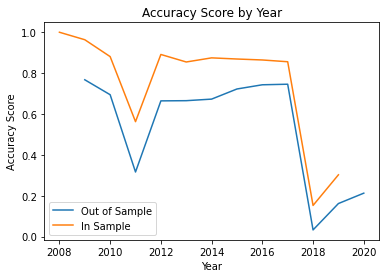

In [59]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years_in_sample = [2008 ,2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, accuracies, label='Out of Sample')
plt.plot(years_in_sample, accuracies_in_sample, label='In Sample')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Year')

Text(0.5, 1.0, 'Out of Sample F1 Scores by Year')

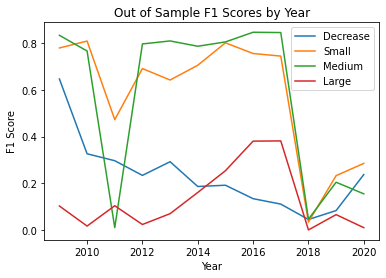

In [46]:
plt.plot(years, f1scores)
plt.legend(['Decrease','Small','Medium','Large'])
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('Out of Sample F1 Scores by Year')

Text(0.5, 1.0, 'In Sample F1 Scores by Year')

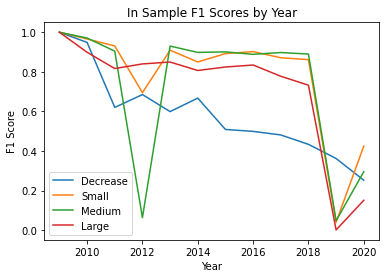

In [48]:
plt.plot(years, f1scores_in_sample)
plt.legend(['Decrease','Small','Medium','Large'])
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('In Sample F1 Scores by Year')

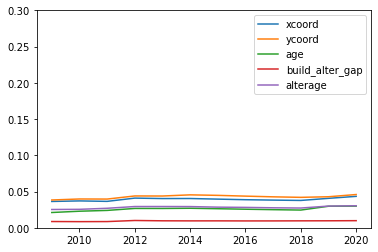

In [54]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][0:5] for i in range(len(feature_importances))])
plt.legend(cov_forest[0:5])

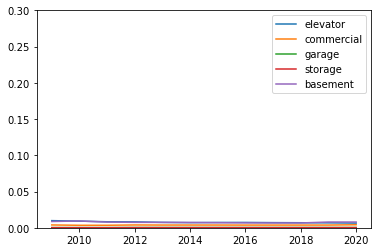

In [55]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][5:10] for i in range(len(feature_importances))])
plt.legend(cov_forest[5:10])

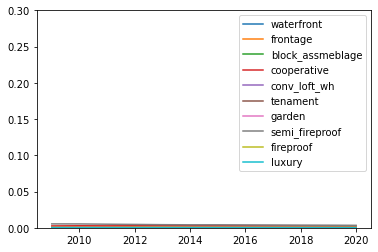

In [51]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][10:20] for i in range(len(feature_importances))])
plt.legend(cov_forest[10:20])

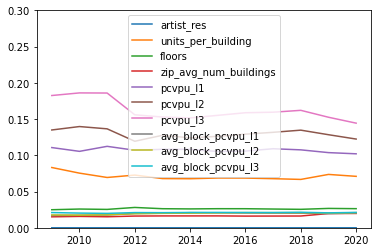

In [52]:
plt.axis([None, None, 0, 0.3])

plt.plot(years, [feature_importances[i][20:30] for i in range(len(feature_importances))])
plt.legend(cov_forest[20:30])

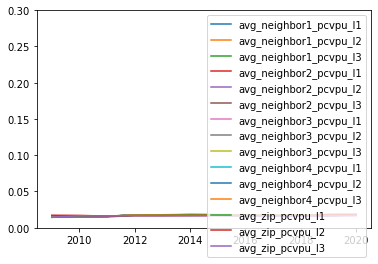

In [53]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][30:] for i in range(len(feature_importances))])
plt.legend(cov_forest[30:])